In [1]:
# Non-stationary harmonic fit on observation data



In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py
from scipy import signal



from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.utils.harmonic_analysis import harmonic_fit_array

import matplotlib as mpl

In [12]:
%matplotlib notebook

In [33]:
# Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_PILKIMTIS.nc'
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'

# ds = xr.concat([xr.open_dataset(ncfile,group='PIL100_2012_a')['A_n'],
#     xr.open_dataset(ncfile,group='PIL100_2012_b')['A_n'],
#     #xr.open_dataset(ncfile,group='PIL100_2013')['A_n'],
#     xr.open_dataset(ncfile,group='PIL100_2014_a')['A_n'] ], dim='time')

# # Do some QC
# ds.loc['2012-05-23':'2012-07-31']=np.nan
# ds.loc['2014-06-08':'2014-06-14']=np.nan


In [111]:
# # Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'

# ds = xr.concat([xr.open_dataset(ncfile,group='PIL200_2012_a')['A_n'],
#     xr.open_dataset(ncfile,group='PIL200_2012_b')['A_n'],
#     xr.open_dataset(ncfile,group='PIL200_2013_a')['A_n'],
#     xr.open_dataset(ncfile,group='PIL200_2013_b')['A_n'],

#     xr.open_dataset(ncfile,group='PIL100_2014_a')['A_n'] ], dim='time')

# # Do some QC
# ds.loc['2014-06-08':'2014-06-13']=np.nan
# # ds.loc['2014-06-08':'2014-06-14']=np.nan


In [118]:
# Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_PILKIMTIS.nc'

ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'

ds = xr.concat([xr.open_dataset(ncfile,group='KIM400_2012_a')['A_n'],
    xr.open_dataset(ncfile,group='KIM400_2012_b')['A_n'],
    xr.open_dataset(ncfile,group='KIM400_2013_a')['A_n'],
    xr.open_dataset(ncfile,group='KIM400_2013_b')['A_n'],
    xr.open_dataset(ncfile,group='KIM400_2014_a')['A_n'] ], dim='time')

# Do some QC (KIM200)
#ds.loc['2013-07-01':'2013-07-31']=np.nan

#(KIM400)
ds.loc['2012-07-30':'2012-08-10']=np.nan
ds.loc['2014-07-10':'2014-08-30']=np.nan

In [126]:
# Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_PILKIMTIS.nc'

ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'

ds = xr.concat([
    xr.open_dataset(ncfile,group='KIM200_2012_b')['A_n'],
    xr.open_dataset(ncfile,group='KIM200_2013_a')['A_n'],
    xr.open_dataset(ncfile,group='KIM200_2013_b')['A_n'],
    xr.open_dataset(ncfile,group='KIM200_2014_a')['A_n'] ], dim='time')

# Do some QC (KIM200)
ds.loc['2013-07-01':'2013-07-31']=np.nan

#(KIM400)
# ds.loc['2012-07-30':'2012-08-10']=np.nan
# ds.loc['2014-07-10':'2014-08-30']=np.nan

<IPython.core.display.Javascript object>


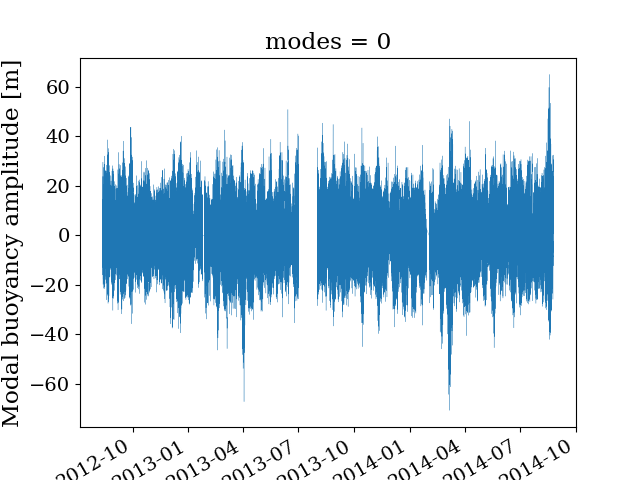

In [128]:
plt.figure()
ds[:,0].plot(lw=0.2)

In [129]:
def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[...,ii]*np.cos(omega[ii]*tdays) + Ba[...,ii]*np.sin(omega[ii]*tdays)
    
    return amp


In [130]:
mode = 0
Xsel = ds[:,mode].sel(time=slice('2013-07-01','2014-07-01'))
#Xsel.loc['2016-09-15':'2016-10-15']=np.nan
idx = ~np.isnan(Xsel.values)


X = Xsel.values[idx]
tnew = Xsel.time.values[idx]

# Break the time series up into chunks
trange = pd.date_range(tnew[0],tnew[-1],freq='15D').values
tmid = trange[0:-1] + 0.5*(trange[1:]-trange[0:-1])

tindex = np.zeros(tnew.shape, np.int)
ii=0
for t1,t2 in zip(trange[0:-1], trange[1:]):
    idx = (tnew>=t1) & (tnew<=t2)
    #print(t1,t2,sum(idx))

    tindex[idx] = ii
    ii+=1

RMSE:  6.934330434844138


<IPython.core.display.Javascript object>


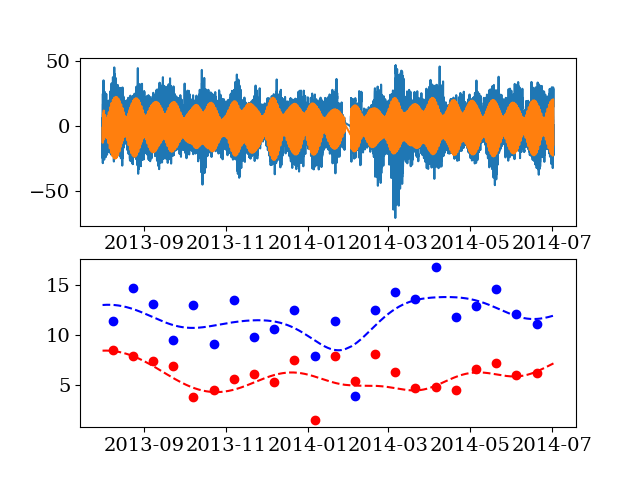

In [132]:
tdaysec = 86400.

tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)
#frqlow = [2*np.pi/(365*tdaysec), 2*np.pi/(180*tdaysec), 2*np.pi/(120*tdaysec)]
omega_A = 2*np.pi/(365*tdaysec)
frqlow = [omega_A, 2*omega_A, 3*omega_A]


# Go through and do the fitting using least-squares
nfrq = len(frq)
nfrqlow = len(frqlow)

tsec = SecondsSince(tnew)
tseclow = SecondsSince(tmid)

nt = tsec.shape[0]
ntlow = tseclow.shape[0]

# 1) Fit the tide harmonics to each 15 d block
aa = np.zeros((ntlow,))
Aa = np.zeros((ntlow, nfrq))
Ba = np.zeros((ntlow, nfrq))

for ii in range(ntlow):
    idx = tindex == ii
    Y = harmonic_fit_array(X[idx], tsec[idx], frq, axis=0)
    aa[ii] = Y[0]
    Aa[ii,:] = Y[1::2]
    Ba[ii,:] = Y[2::2]


# 2) Fit the low-frequency harmonics to these harmonics
aa_l_r = np.zeros((nfrq,))
Aa_l_r = np.zeros((nfrqlow,nfrq))
Ba_l_r = np.zeros((nfrqlow,nfrq))

aa_l_i = np.zeros((nfrq,))
Aa_l_i = np.zeros((nfrqlow,nfrq))
Ba_l_i = np.zeros((nfrqlow,nfrq))

#Y = harmonic_fit_array(aa, tseclow, frqlow, axis=0)
#aa_l_r[:] = Y[1::2]
#aa_l_i[:] = Y[2::2]

Y = harmonic_fit_array(Aa, tseclow, frqlow, axis=0)
aa_l_r[:] = Y[0,:]
Aa_l_r[:] = Y[1::2,:]
Aa_l_i[:] = Y[2::2,:]

Y = harmonic_fit_array(Ba, tseclow, frqlow, axis=0)
aa_l_i[:] = Y[0,:]
Ba_l_r[:] = Y[1::2,:]
Ba_l_i[:] = Y[2::2,:]

## Prediction
# 3) Build the tidal harmonics as a time-series
Aa_pred = np.zeros((nt,nfrq))
Ba_pred = np.zeros((nt,nfrq))

for ii in range(nfrq):
    Aa_pred[:,ii] = harmonic_pred(aa_l_r[ii], Aa_l_r[:,ii], Aa_l_i[:,ii], frqlow, tsec)
    Ba_pred[:,ii] = harmonic_pred(aa_l_i[ii], Ba_l_r[:,ii], Ba_l_i[:,ii], frqlow, tsec)


# 4) Predict the raw amplitude
a0 = harmonic_pred(0, Aa_pred, Ba_pred, frq, tsec)

print('RMSE: ',rmse(X,a0))

plt.figure()
plt.subplot(211)
plt.plot(tnew,X)
plt.plot(tnew,a0)

plt.subplot(212)
plt.plot(tmid, np.abs(Aa[:,0] + 1j*Ba[:,0]),'bo')
plt.plot(tnew, np.abs(Aa_pred[:,0] + 1j*Ba_pred[:,0]),'b--')

ff = 1
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'ro')
plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'r--')



6.04282965460696